In [ ]:
import pandas as pd
df = pd.read_csv('/content/fin_df_with_url.csv')
# df = df['text'].dropna()

In [ ]:
text = list(df.text)

In [ ]:
type(text)

list

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text, show_progress_bar=True)

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
embeddings.shape

(1359, 768)

In [ ]:
!pip uninstall umap
!pip install umap-learn

In [ ]:
from umap import UMAP
umap_embeddings = UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
umap_embeddings.shape

(1359, 5)

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311889 sha256=18ffa473f366d029c9ac46012f679de0143e8f4a1420bd617c3cea269a4f5b79
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
cluster.labels_

array([ 1,  0,  1, ...,  1,  1, -1])

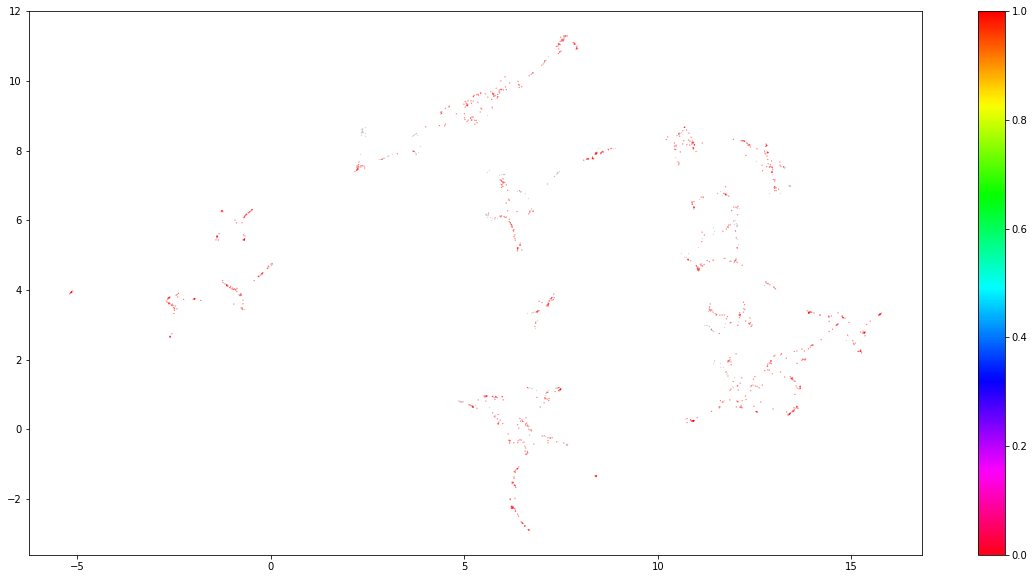

In [ ]:
import matplotlib.pyplot as plt
import umap
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.00, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
docs_df = pd.DataFrame(text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
# docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_per_topic = docs_df.assign(Doc = docs_df['Doc'].astype(str)).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': lambda x: ' '.join(x.astype(str))})

In [ ]:
docs_df

,Doc,Topic,Doc_ID
0,My name is Vi. And I am 28 years old. I arrive...,1,0
1,Thank you for the opportunity to testify befor...,0,1
2,My sister and I were living in a village. We w...,1,2
3,I grew up in a village of between 500 and 700 ...,1,3
4,"I was living in a village, Karko, in the Nuba ...",1,4
...,...,...,...
1354,"In Nigeria, it was difficult to make a living....",1,1354
1355,"My name is Seif Eldein. I’m 24 years old, from...",1,1355
1356,I was begging and sleeping in the street behin...,1,1356
1357,I lived with my mother and father and they wer...,1,1357


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
2,1,1093
0,-1,247
1,0,18


In [ ]:
top_n_words

{-1: [('told', 0.019298783378574328),
  ('work', 0.017971469495837077),
  ('said', 0.01643707317370806),
  ('money', 0.015148842787611626),
  ('people', 0.015012957961735336),
  ('day', 0.014440286777640839),
  ('time', 0.013857617222761928),
  ('know', 0.01355356885630042),
  ('like', 0.013331016115999501),
  ('didn', 0.013204154429135823),
  ('going', 0.012979891973340311),
  ('just', 0.012967681914520248),
  ('house', 0.012607244284852171),
  ('came', 0.012591527794075219),
  ('did', 0.01259133884992303),
  ('took', 0.012457661867288363),
  ('mother', 0.012227609454543861),
  ('home', 0.012205525814356178),
  ('went', 0.011727648855165257),
  ('family', 0.01156678737112555)],
 0: [('trafficking', 0.03880509497969685),
  ('human', 0.022627548327348427),
  ('slavery', 0.021566190668577664),
  ('north', 0.021335821461064233),
  ('children', 0.019154735059226387),
  ('survivors', 0.018132917082090826),
  ('child', 0.017792763828131893),
  ('like', 0.017789476433164315),
  ('korean', 0.0

In [ ]:
#route patterns identified - e.g. East Africa context (conflicts) + routes in topic 0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    # docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    # old_topics = docs_df.sort_values("Topic").Topic.unique()
    # map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    # docs_df.Topic = docs_df.Topic.map(map_topics)
    # docs_per_topic = docs_df.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': lambda x: ' '.join(x.dropna())})


    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
top_n_words

In [ ]:
import wordcloud
#debt bondage - topic 1
wordcloud = wordcloud.WordCloud(background_color="white",mode='RGB', width=900,height=500, max_words=100,relative_scaling=0.6,normalize_plurals=False).generate_from_frequencies(dict(top_n_words[1]))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#E Africa - topic 0
import wordcloud
wordcloud = wordcloud.WordCloud(background_color="white",mode='RGB', width=900,height=500, max_words=100,relative_scaling=0.6,normalize_plurals=False).generate_from_frequencies(dict(top_n_words[0]))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
# Load the image
mask = np.array(Image.open( "africashape.png"))

wc_text = top_n_words[0]

wordcloud = WordCloud(mask=mask).generate(wc_text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()